In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [ ]:
time = np.arange(4*365+1, dtype='float32')
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level=5

In [ ]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [ ]:
series

array([ 52.48357 ,  49.35275 ,  53.314735, ...,  91.37325 ,  88.32383 ,
       122.30772 ], dtype=float32)

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

In [ ]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

In [ ]:
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.05888816],
       [ 0.03278662],
       [ 0.01283124],
       [-0.02057301],
       [ 0.05166546],
       [-0.05561401],
       [ 0.01522274],
       [ 0.07634929],
       [-0.07801022],
       [ 0.08356929],
       [-0.12316641],
       [ 0.05741252],
       [-0.00985711],
       [-0.01573311],
       [ 0.0414662 ],
       [ 0.1484017 ],
       [-0.05955151],
       [ 0.10328792],
       [ 0.30953634],
       [ 0.47619918]], dtype=float32), array([0.0158102], dtype=float32)]


In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast

[array([[44.130558]], dtype=float32),
 array([[47.91232]], dtype=float32),
 array([[49.178856]], dtype=float32),
 array([[48.82707]], dtype=float32),
 array([[42.168697]], dtype=float32),
 array([[45.719837]], dtype=float32),
 array([[46.19774]], dtype=float32),
 array([[42.645683]], dtype=float32),
 array([[46.151077]], dtype=float32),
 array([[44.373966]], dtype=float32),
 array([[44.04024]], dtype=float32),
 array([[44.296127]], dtype=float32),
 array([[46.72377]], dtype=float32),
 array([[49.676]], dtype=float32),
 array([[43.602467]], dtype=float32),
 array([[43.322346]], dtype=float32),
 array([[44.976147]], dtype=float32),
 array([[42.081093]], dtype=float32),
 array([[39.0969]], dtype=float32),
 array([[37.57986]], dtype=float32),
 array([[40.313515]], dtype=float32),
 array([[43.431465]], dtype=float32),
 array([[42.840965]], dtype=float32),
 array([[41.49611]], dtype=float32),
 array([[39.85294]], dtype=float32),
 array([[39.452377]], dtype=float32),
 array([[34.685265]], dty

In [ ]:
forecast = forecast[split_time-window_size:]
forecast

[array([[63.382923]], dtype=float32),
 array([[68.89921]], dtype=float32),
 array([[68.85978]], dtype=float32),
 array([[66.252014]], dtype=float32),
 array([[61.69721]], dtype=float32),
 array([[66.08455]], dtype=float32),
 array([[65.611916]], dtype=float32),
 array([[66.11186]], dtype=float32),
 array([[66.24287]], dtype=float32),
 array([[68.06652]], dtype=float32),
 array([[64.29452]], dtype=float32),
 array([[66.76133]], dtype=float32),
 array([[66.2239]], dtype=float32),
 array([[71.630226]], dtype=float32),
 array([[64.58865]], dtype=float32),
 array([[69.47913]], dtype=float32),
 array([[65.23619]], dtype=float32),
 array([[65.336136]], dtype=float32),
 array([[60.84817]], dtype=float32),
 array([[63.920006]], dtype=float32),
 array([[63.571453]], dtype=float32),
 array([[66.36403]], dtype=float32),
 array([[60.955307]], dtype=float32),
 array([[65.09536]], dtype=float32),
 array([[67.19516]], dtype=float32),
 array([[73.01236]], dtype=float32),
 array([[68.27134]], dtype=floa

In [ ]:
results = np.array(forecast)[:, 0, 0]

In [ ]:
results

array([ 63.382923,  68.89921 ,  68.85978 ,  66.252014,  61.69721 ,
        66.08455 ,  65.611916,  66.11186 ,  66.24287 ,  68.06652 ,
        64.29452 ,  66.76133 ,  66.2239  ,  71.630226,  64.58865 ,
        69.47913 ,  65.23619 ,  65.336136,  60.84817 ,  63.920006,
        63.571453,  66.36403 ,  60.955307,  65.09536 ,  67.19516 ,
        73.01236 ,  68.27134 ,  64.566666,  66.64365 ,  66.54607 ,
        62.95544 ,  62.56846 ,  58.648438,  63.26668 ,  63.98621 ,
        63.636024,  66.83746 ,  63.99655 ,  59.827343,  62.05993 ,
        66.64077 ,  71.8101  ,  64.27232 ,  66.28852 ,  66.41575 ,
        64.02218 ,  67.84274 ,  67.001335,  62.708004,  66.01768 ,
        67.38441 ,  69.368034,  62.506702,  67.173615,  67.94137 ,
        62.652233,  62.44055 ,  64.873055,  67.04861 ,  68.02996 ,
        63.86401 ,  65.80124 ,  60.84897 ,  63.14487 ,  61.145996,
        63.62834 ,  58.19354 ,  61.040268,  63.96506 ,  64.6573  ,
        64.41858 ,  66.58096 ,  64.01286 ,  68.77573 ,  60.520

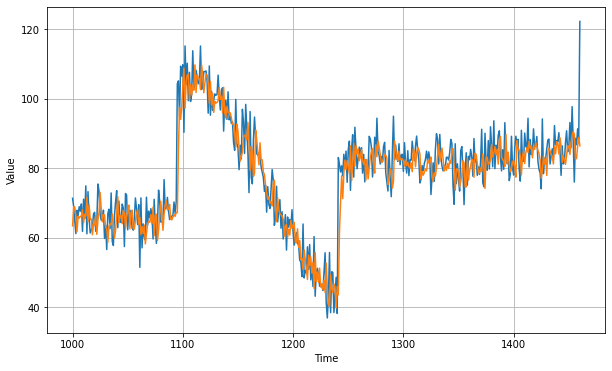

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.16671